In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,roc_curve, auc
from torch.utils.data.dataset import Dataset

In [ ]:
class NumpyDataset(Dataset):
    """This class allows you to convert numpy.array to torch.Dataset

    Args:
        x (np.array):
        y (np.array):
        transform (torch.transform):

    Attriutes
        x (np.array):
        y (np.array):
        transform (torch.transform):
    """

    def __init__(self, x, y=None, transform=None, return_idx=False):
        self.x = x
        self.y = y
        self.transform = transform
        self.return_idx = return_idx

    def __getitem__(self, index):
        x = self.x[index]
        if self.y is not None:
            y = self.y[index]

        if self.transform is not None:
            x = self.transform(x)

        if not self.return_idx:
            if self.y is not None:
                return x, y
            else:
                return x
        else:
            if self.y is not None:
                return index, x, y
            else:
                return index, x

    def __len__(self):
        """get the number of rows of self.x"""
        return len(self.x)

In [ ]:
class FirstNet(nn.Module):
    def __init__(self, train_features, hidden_dim):
        super(FirstNet, self).__init__()
        self.L1 = nn.Linear(train_features.shape[-1], hidden_dim)

    def forward(self, x):
        x = self.L1(x)
        x = nn.functional.relu(x)
        return x


class SecondNet(nn.Module):
    def __init__(self, hidden_dim):
        super(SecondNet, self).__init__()
        self.L2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.L2(x)
        x = torch.sigmoid(x)
        return x

In [ ]:
batch_size = 512
hidden_dim = 16
torch.manual_seed(10)

In [ ]:
raw_df = pd.read_csv(
    "https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv"
)
raw_df_neg = raw_df[raw_df["Class"] == 0]
raw_df_pos = raw_df[raw_df["Class"] == 1]

down_df_neg = raw_df_neg  # .sample(40000)
down_df = pd.concat([down_df_neg, raw_df_pos])

neg, pos = np.bincount(down_df["Class"])
total = neg + pos
print(
    "Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n".format(
        total, pos, 100 * pos / total
    )
)

cleaned_df = down_df.copy()
# You don't want the `Time` column.
cleaned_df.pop("Time")
# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001  # 0 => 0.1¢
cleaned_df["Log Ammount"] = np.log(cleaned_df.pop("Amount") + eps)

cleaned_df

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Log Ammount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,5.008105
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.989913
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,5.936641
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,4.816249
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,4.248367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279863,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,-5.587794,...,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,1,5.966149
280143,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,-3.232153,...,0.370612,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,1,-0.273122
280149,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,-3.463891,...,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,1,4.355310
281144,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,-5.245984,...,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,1,5.501262


In [ ]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop("Class"))
test_labels = np.array(test_df.pop("Class"))

train_features = np.array(train_df)
test_features = np.array(test_df)

scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
train_features = np.clip(train_features, -5, 5)

test_features = scaler.fit_transform(test_features)
test_features = np.clip(test_features, -5, 5)

train_dataset = NumpyDataset(
    train_features, train_labels.astype(np.float64).reshape(-1, 1)
)
test_dataset = NumpyDataset(
    test_features, test_labels.astype(np.float64).reshape(-1, 1)
)


train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

In [ ]:
client_model = FirstNet(train_features, hidden_dim)
server_model = SecondNet(hidden_dim)

client_optimizer = torch.optim.Adam(client_model.parameters(), lr=0.001)
server_optimizer = torch.optim.Adam(server_model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Initialization
num_epochs = 10
train_acc_list = []
train_loss_list = []
all_labels = []
all_predictions = []

for epoch in range(num_epochs):
    client_model.train()
    server_model.train()
    correct = 0
    total = 0
    total_loss = 0

    for features, labels in train_loader:
        features = features.float()
        labels = labels.float()
        # Client side
        client_optimizer.zero_grad()
        intermediate_features = client_model(features)

        # Send to server
        server_optimizer.zero_grad()
        outputs = server_model(intermediate_features)

        loss = criterion(outputs, labels)
        loss.backward()

        # Update both server and client models
        server_optimizer.step()
        client_optimizer.step()

        # Update accuracy and loss stats
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        total_loss += loss.item()

        # Store outputs for ROC computation
        all_labels.extend(labels.cpu().detach().numpy())
        all_predictions.extend(outputs.cpu().detach().numpy())

    # Calculate and store average accuracy and loss for each epoch
    epoch_acc = correct / total
    epoch_loss = total_loss / len(train_loader)
    train_acc_list.append(epoch_acc)
    train_loss_list.append(epoch_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc * 100:.2f}%")

Epoch 1/10, Loss: 0.1455, Accuracy: 99.82%
Epoch 2/10, Loss: 0.0113, Accuracy: 99.92%
Epoch 3/10, Loss: 0.0056, Accuracy: 99.94%
Epoch 4/10, Loss: 0.0042, Accuracy: 99.94%
Epoch 5/10, Loss: 0.0036, Accuracy: 99.94%
Epoch 6/10, Loss: 0.0033, Accuracy: 99.94%
Epoch 7/10, Loss: 0.0031, Accuracy: 99.94%
Epoch 8/10, Loss: 0.0030, Accuracy: 99.94%
Epoch 9/10, Loss: 0.0029, Accuracy: 99.95%
Epoch 10/10, Loss: 0.0028, Accuracy: 99.95%


In [ ]:
attack_labels = []
attack_gradient_norms = []

for features, labels in train_loader:
    features = features.float()
    labels = labels.float()
    features.requires_grad_()

    # forward pass on client side
    intermediate_features = client_model(features)

    # send intermediate features to server to continue forward pass
    outputs = server_model(intermediate_features)

    # server does back propagation to compute gradients
    loss = criterion(outputs, labels)
    loss.backward()

    # client computes 2-norm of the gradients received from server
    grad_norm = features.grad.pow(2).sum(dim=1).sqrt()

    # store gradient norms and actual labels for later comparison
    attack_labels.append(labels)
    attack_gradient_norms.append(grad_norm)

attack_labels = torch.cat(attack_labels)
attack_gradient_norms = torch.cat(attack_gradient_norms)

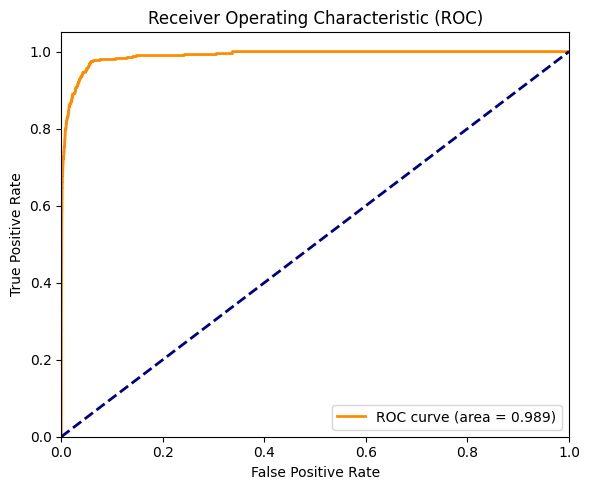

In [ ]:
from sklearn.metrics import roc_curve, auc

# Plot ROC graph to evaluate
plt.figure(figsize=(6, 5))

# Plot ROC curve and compute AUC to evaluate predictions
fpr, tpr, _ = roc_curve(attack_labels, attack_gradient_norms)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [ ]:
# Put the models in evaluation mode
client_model.eval()
server_model.eval()

correct = 0
total = 0
test_labels = []
test_predictions = []

# Get predictions on test set
for features, labels in test_loader:
    features = features.float()
    labels = labels.float()

    intermediate_features = client_model(features)
    outputs = server_model(intermediate_features)

    predicted = (outputs > 0.5).float()  # Assuming binary classification
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    test_labels.extend(labels.cpu().detach().numpy())
    test_predictions.extend(outputs.cpu().detach().numpy())

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Compute ROC curve and ROC area for test set
fpr, tpr, _ = roc_curve(test_labels, test_predictions)
roc_auc = auc(fpr, tpr)

Test Accuracy: 99.95%


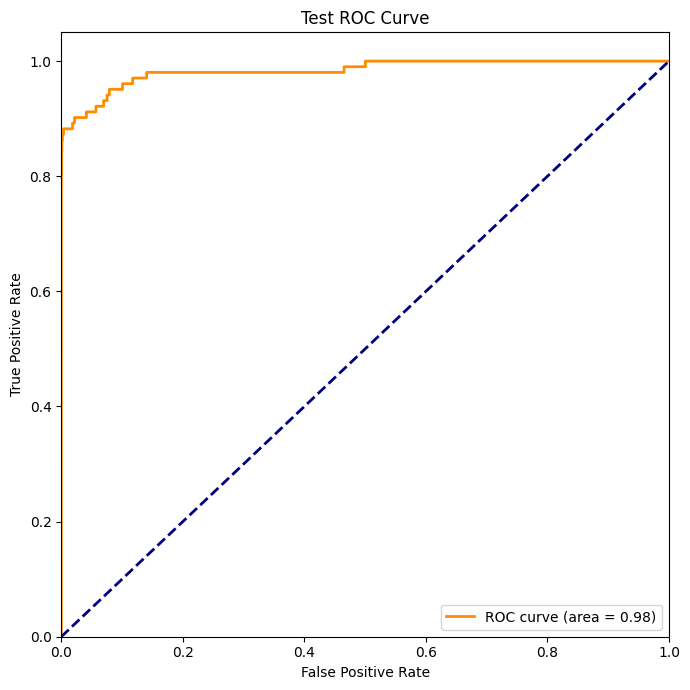

In [ ]:
# Plotting ROC curve for test set
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test ROC Curve')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()